In [9]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt
from sub_functions.materials import W
from sub_functions.custom_classes import CustomHeatSolver, CustomHeatSource
import sympy as sp
import fenics as f
from scipy import special

def custom_exp(x):
    if isinstance(x, np.ndarray):
        return np.exp(x)
    else:
        return f.exp(x)
    
alpha_W = 0.4
sigma = 5.67e-8
T0 = 300

E_dt1 = 1.53
E_dt2 = 1.5
eta1 = 1e-5
eta2 = 0.e-5
Elim = 0.2
E_inc = 100

vertices = np.concatenate(
    [
        np.linspace(0, 1e-6, 1000),
        np.linspace(1e-6, 10e-6, 500),
        np.linspace(10e-6, 100e-6, 500),
        np.linspace(100e-6, 2e-3, 200),
    ]
)

R_impl = 4.35e-9
sigma_impl = 3.185e-9
#final_time = 10 * (15*60 + 1e-3) + 1e4
final_time = 1e5

trap_distr = 1
Ec = 0.

In [10]:
def normal_distr(X, sigma):
    """
    :param X: Range
    :type X: float
    :param sigma: Width
    :type sigma: float
    """
    return 2 / (1 + special.erf(X / np.sqrt(2) / sigma))

def q_heat(t):

    #t = t % (15*60)
    E0 = 0.7e6

    t1 = 1.73891412e-05
    t2 = 6.01227240e-04
    dt1 = 3.31805703e-06
    delta = 3.53224724e-01
    dt2 = 2.55841858e-04
    norm = 0.0007774

    f1 = lambda t: 0.8 / (1 + sp.exp(-(t - 0.5 * t1) / dt1))
    f2 = lambda t: 1 + delta * (t - t1) / (t2 - t1)
    f3 = lambda t: sp.exp(-(t - t2) / dt2)

    return (
        E0
        * sp.Piecewise(
            (f1(t), t <= t1),
            (f1(t1) * f2(t), (t > t1) & (t <= t2)),
            (f1(t1) * f2(t2) * f3(t), True),
        )
        / norm
    )


def q_rad(T, mobile):
    return -alpha_W * sigma * (T**4 - T0**4)


def heat_loss(T):
    return -1.2e3 * W().thermal_cond_function(T) * (T - T0)


model = F.Simulation()

model.mesh = F.MeshFromVertices(vertices=vertices)

mat = W()

model.materials = F.Material(
    id=1,
    D_0=mat.D_0,
    E_D=mat.E_diff,
    thermal_cond=mat.thermal_cond_function,
    rho=mat.rho,
    heat_capacity=mat.heat_capacity_function,
    Q=mat.heat_of_transport_function,
)

trap1 = F.Trap(
    k_0=mat.nu_D / mat.n_IS,
    E_k=mat.E_diff,
    p_0=mat.nu_0,
    E_p=E_dt1,
    density=eta1 * mat.n_mat,
    materials=model.materials[0],
)

trap2 = F.Trap(
    k_0=mat.nu_D / mat.n_IS,
    E_k=mat.E_diff,
    p_0=mat.nu_0,
    E_p=E_dt2,
    density=eta2 * mat.n_mat,
    materials=model.materials[0],
)

model.traps = [trap1, trap2]

model.sources = [
    CustomHeatSource(function=heat_loss, field="T", volume=1),
    F.ImplantationFlux(
        flux=q_heat(F.t) / E_inc / 1.6e-19 * normal_distr(R_impl, sigma_impl) * (1-0.65), imp_depth=R_impl, width=sigma_impl, volume=1
    ),
]

def Qc(cs):
    theta = cs / mat.n_surf

    return -(7.4e-2 + 0.98 / (1 + custom_exp((theta - 0.74) / 0.027))) * (1 - 1*custom_exp(-9.4 * (1 - theta)))
    
def k_sb(T, cs, cm):
    return mat.nu_0 * f.exp(-(mat.E_diff + mat.Q_s - Qc(cs)) / F.k_B / T)

def k_bs(T, cs, cm):
    return mat.nu_0 * mat.lambda_abs * f.exp(-mat.E_diff / F.k_B / T)

def J_vs(T, cs, cm):
    if isinstance(cs, np.ndarray):
        custom_exp = lambda x: np.exp(x)
    else:
        custom_exp = lambda x: f.exp(x)
        
    J_des = 2 * mat.nu_0 * cs**2 / mat.n_surf * custom_exp(-2*(Ec-Qc(cs)) / F.k_B / T)
    
    return -J_des

BC_left = F.SurfaceKinetics(
    k_sb=k_sb,
    k_bs=k_bs,
    lambda_IS=mat.lambda_IS,
    n_surf=mat.n_surf,
    n_IS=mat.n_IS,
    J_vs=J_vs,
    surfaces=1,
    initial_condition=0
)

# BC_left = F.RecombinationFlux(Kr_0=2e-15, E_Kr=1.7, order=2, surfaces=1)
# BC_left = F.DirichletBC(surfaces=1, value=0, field=0)

model.boundary_conditions = [
    F.DirichletBC(surfaces=2, value=0, field=0),
    BC_left,
    F.FluxBC(surfaces=1, value=q_heat(F.t), field="T"),
    F.CustomFlux(surfaces=[1, 2], function=q_rad, field="T"),
]

model.T = CustomHeatSolver(
    transient=True,
    initial_condition=T0,
    absolute_tolerance=1.0,
    relative_tolerance=1e-3,
)

def dt(t):
    if t < 2e-3:
        return 1e-5
    elif t < 1:
        return 1
    else:
        return 1000

model.dt = F.Stepsize(
    initial_value=1e-7,
    max_stepsize=dt,
    dt_min=1e-9,
    stepsize_change_ratio=1.05,
    milestones=[final_time]
)

model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    transient=True,
    final_time=final_time,
    maximum_iterations=30,
    soret=True,
    traps_element_type="DG"
)

derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume(field="retention", volume=1),
        F.TotalSurface(field="T", surface=1),
        F.TotalSurface(field="T", surface=2),
        F.AdsorbedHydrogen(surface=1),
    ],
    filename="./results/test.csv",
)

TXT = [
    F.TXTExport(
        field="retention", filename="./results//retention.txt", times=[final_time], write_at_last=True
    ),
    F.TXTExport(
        field="solute", filename="./results/solute.txt", times=[final_time], write_at_last=True
    ),
    F.TXTExport(
        field="1", filename="./results/trap1.txt", times=[final_time], write_at_last=True
    ),
    F.TXTExport(
        field="2", filename="./results/trap2.txt", times=[final_time], write_at_last=True
    ),
]

XDMF = [
    F.XDMFExport(
        field=0, label="mobile", filename="results/mobile.xdmf", checkpoint=True, mode="last"
    ),
    F.XDMFExport(
        field="1", label="trap1", filename="results/trap1.xdmf", checkpoint=True, mode="last"
    ),
    F.XDMFExport(
        field="2", label="trap2", filename="results/trap2.xdmf", checkpoint=True, mode="last"
    ),
]

model.exports = [derived_quantities] + TXT + XDMF


model.initialise()
model.run()

Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+05 s    Elapsed time so far: 118.8 s


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/xdmf_export.py:132: UserWarning: in 1D, checkpoint needs to be set to False to visualise the XDMF file in Paraview (see issue https://github.com/festim-dev/festim/issues/134)
  warnings.warn(msg)


/tmp/ipykernel_1805/2360241837.py:45: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim(0, final_time)


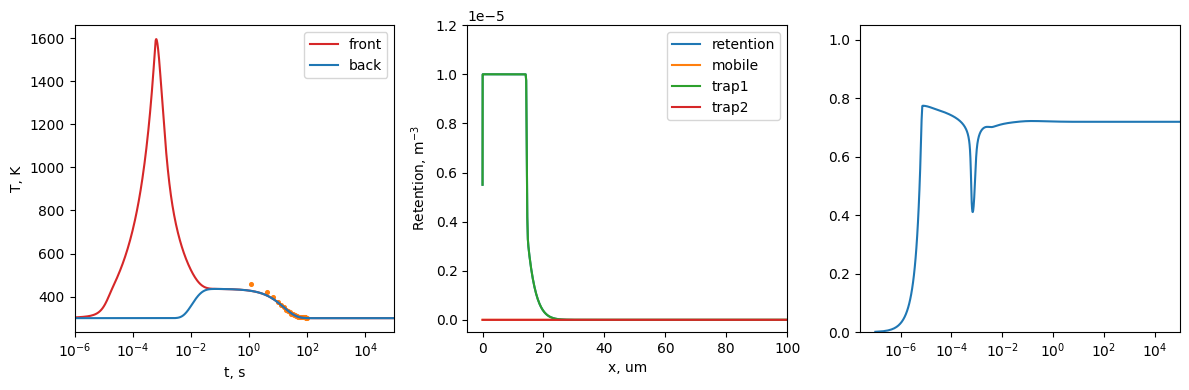

Bulk: 9.721660384922202e+18
Surface: 1.436848755762991e+19


In [11]:
t = np.array(derived_quantities.t)
retention = np.array(derived_quantities[0].data)
T_front = np.array(derived_quantities[1].data)
T_back = np.array(derived_quantities[2].data)
cs = np.array(derived_quantities[3].data)

exp = np.loadtxt("./T_back_exp.csv", delimiter=",", skiprows=1)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(t, T_front, label="front", color="tab:red")
axs[0].plot(t, T_back, label="back", color="tab:blue")

axs[0].scatter(exp[:, 0], exp[:, 1], s=7, color="tab:orange")


axs[0].set_xlim(1e-6, final_time)
axs[0].set_xscale("log")
axs[0].set_xlabel("t, s")
axs[0].set_ylabel("T, K")
axs[0].legend()


"""plt.plot(t, retention / 2e-3 / mat.n_mat)
plt.xlim(0, 0.1)
plt.show()"""

axs[1].plot(TXT[0].data[:, 0] / 1e-6, TXT[0].data[:, -1] / mat.n_mat, label="retention")
axs[1].plot(TXT[1].data[:, 0] / 1e-6, TXT[1].data[:, -1] / mat.n_mat, label="mobile")
axs[1].plot(TXT[2].data[:, 0] / 1e-6, TXT[2].data[:, -1] / mat.n_mat, label="trap1")
axs[1].plot(TXT[3].data[:, 0] / 1e-6, TXT[3].data[:, -1] / mat.n_mat, label="trap2")
# plt.xscale("log")

#axs[1].set_yscale("log")
#axs[1].set_xscale("log")
axs[1].set_ylim(top=1.2e-5)
axs[1].set_xlim(-5, 100)
axs[1].set_xlabel("x, um")
axs[1].set_ylabel(r"Retention, m$^{-3}$")
axs[1].legend()

axs[2].plot(t, cs / mat.n_surf)
axs[2].set_xscale("log")
axs[2].set_ylim(0, 1.05)
axs[2].set_xlim(0, final_time)

plt.tight_layout()
plt.show()

print(f"Bulk: {np.trapz(TXT[0].data[:, -1], x=TXT[0].data[:, 0])}" )
print(f"Surface: {cs[-1]}")

In [12]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt

T0 = 300
ramp = 2
start_TDS_time = 0
TDS_time = 750

model_TDS = F.Simulation()

model_TDS.mesh = F.MeshFromVertices(vertices=vertices)

model_TDS.materials = F.Material(
    id=1,
    D_0=mat.D_0,
    E_D=mat.E_diff,
)

model_TDS.traps = model.traps

BC_left.initial_condition = cs[-1]

model_TDS.boundary_conditions = [
    F.DirichletBC(surfaces=[2], value=0, field=0),
    BC_left,
]

model_TDS.initial_conditions = [
    F.InitialCondition(
        field=0, 
        value="./results/mobile.xdmf",
        label="mobile", 
        time_step=-1
        ),
    F.InitialCondition(
        field="1", 
        value="./results/trap1.xdmf",
        label="trap1", 
        time_step=-1
        ),
    F.InitialCondition(
        field="2", 
        value="./results/trap2.xdmf",
        label="trap2", 
        time_step=-1
        ),
]

T_value = sp.Piecewise(
    (T0 + ramp * (F.t - start_TDS_time), F.t >= start_TDS_time),  # increase temp after sometime
    (T0, True)  # otherwise T=300.1
)
model_TDS.T = F.Temperature(value=T_value)

model_TDS.dt = F.Stepsize(
    initial_value=1e-6,
    max_stepsize=1,
    dt_min=1e-8,
    stepsize_change_ratio=1.2,
)

model_TDS.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    transient=True,
    final_time=start_TDS_time + TDS_time,
    maximum_iterations=60,
)

derived_quantities = F.DerivedQuantities(
    [
        F.HydrogenFlux(surface=1),
        F.TotalSurface(field="T", surface=1),
        F.TotalVolume(field="retention", volume=1),
        F.TotalVolume(field="1", volume=1),
        F.TotalVolume(field="2", volume=1),
        F.AdsorbedHydrogen(surface=1),
        F.HydrogenFlux(surface=2),
    ],
    filename="./results/test.csv",
)

XDMF = [
    F.XDMFExport(
        field=0, label="mobile", filename="results/mobile_TDS.xdmf", checkpoint=False, mode=1
    ),
    F.XDMFExport(
        field="1", label="trap1", filename="results/trap1_TDS.xdmf", checkpoint=False, mode=1
    ),
    F.XDMFExport(
        field="2", label="trap2", filename="results/trap2_TDS.xdmf", checkpoint=False, mode=1
    ),
]

model_TDS.exports = [derived_quantities] # + XDMF


model_TDS.initialise()
model_TDS.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        7.5e+02 s    Elapsed time so far: 46.2 s


FESTIM: 2.41e+19  m^-2
FESTIM diff flux: 9.68e+18  m^-2
Exp.: 3.31e+19 m^-2
Exp.: 2.47e+19 m^-2
Exp.: 2.59e+19 m^-2


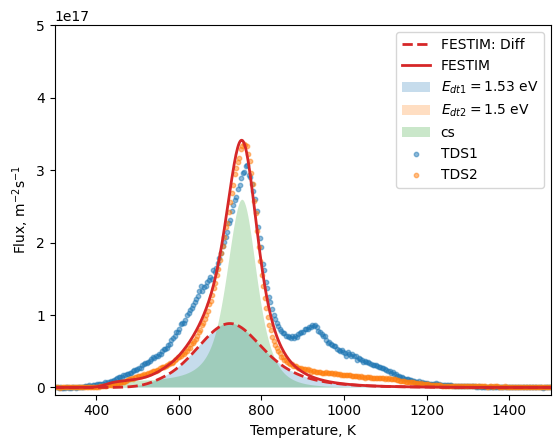

In [13]:
t = np.array(derived_quantities.t)
flux = -np.array(derived_quantities[0].data)
T = np.array(derived_quantities[1].data)
cs_data = np.array(np.array(derived_quantities[-2].data))

trap1_data = np.array(derived_quantities[3].data)
trap2_data = np.array(derived_quantities[4].data)

dtr1 = -np.diff(trap1_data)/np.diff(t)
dtr2 = -np.diff(trap2_data)/np.diff(t)
dcs = -np.diff(cs_data)/np.diff(t)

exp_TDS = np.loadtxt("TDS_07MJ.txt", delimiter=" ", skiprows=1)
exp_TDS2 = np.loadtxt("TDS_07MJ_2.txt", delimiter=" ", skiprows=1)
exp_TDS_04 = np.loadtxt("TDS_04MJ.txt", delimiter=" ", skiprows=1)

plt.plot(T, flux, ls='dashed', color="tab:red", lw=2, label="FESTIM: Diff")
plt.plot(T, -J_vs(T, cs_data, _), label="FESTIM", color='tab:red', lw=2)


plt.fill_between(T[1:], np.zeros_like(dtr1), dtr1, alpha=0.25, lw=0, zorder=-2, label=r"$E_{dt1}=$"+f"{E_dt1} eV")
plt.fill_between(T[1:], np.zeros_like(dtr2), dtr2, alpha=0.25, lw=0, zorder=-2, label=r"$E_{dt2}=$"+f"{E_dt2} eV")
plt.fill_between(T[1:], np.zeros_like(dtr2), dcs, alpha=0.25, lw=0, zorder=-2, label="cs")

plt.scatter(exp_TDS[:,0], exp_TDS[:,1]*1e4, s=10, alpha=0.5, zorder=-1, label="TDS1", color="tab:blue")
plt.scatter(exp_TDS2[:,0], exp_TDS2[:,1]*1e4, s=10, alpha=0.5, zorder=-1, label="TDS2", color="tab:orange")
#plt.scatter(exp_TDS_04[:,0], exp_TDS_04[:,1]*1e4, s=10, alpha=0.5, zorder=-1, label="TDS2")

print(f"FESTIM: {np.trapz(-J_vs(T, cs_data, _), x=t):.2e}  m^-2")
print(f"FESTIM diff flux: {np.trapz(flux, x=t):.2e}  m^-2")
print(f"Exp.: {np.trapz(exp_TDS[:,1]*1e4, x=(exp_TDS[:,0]-300)/ramp):.2e} m^-2")
print(f"Exp.: {np.trapz(exp_TDS2[:,1]*1e4, x=(exp_TDS2[:,0]-300)/ramp):.2e} m^-2")
print(f"Exp.: {np.trapz(exp_TDS_04[:,1]*1e4, x=(exp_TDS_04[:,0]-300)/ramp):.2e} m^-2")

plt.xlim(300, 1500)
plt.ylabel(r"Flux, m$^{-2}$s$^{-1}$")
plt.xlabel(r"Temperature, K")
plt.legend()
plt.ylim(-0.1e17, 5e17)
plt.show()

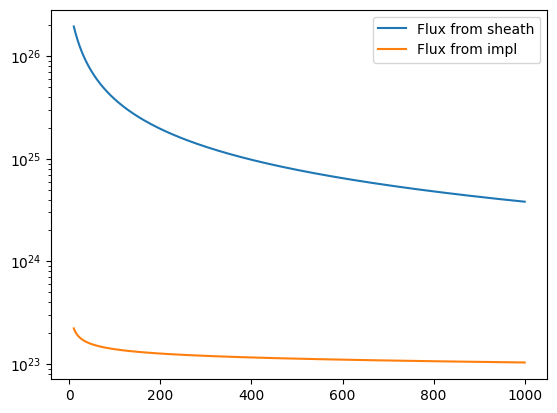

In [14]:
def r_en(E):
    a1 = 0.2547
    a2 = -0.1146
    a3 = 0.1195e1
    a4 = 0.1259e1
    eps_L = 9.92326e3
    eps = E / eps_L

    return a1 * eps ** a2 / (1 + a3 * eps ** a4)

def r_part(E):
    a1 = 0.4453
    a2 = -0.8079e-1
    a3 = 0.5964
    a4 = 0.1344e1
    eps_L = 9.92326e3
    eps = E / eps_L

    return a1 * eps ** a2 / (1 + a3 * eps ** a4)

E = np.linspace(10, 1e3, 10000)

Te = E / 4.85
e = 1.6e-19

gamma_sheath = 0.7e9 / ((4.85 * (1 - r_en(E)) + 2.15) * Te + 13.6) / e

gamma_impl = 2.47e22*2 / (1 - r_part(E))

plt.plot(E, gamma_sheath, label = "Flux from sheath")
plt.plot(E, gamma_impl , label = "Flux from impl")
plt.yscale('log')
plt.legend()
plt.show()